In [137]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import itertools
import copy
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

In [2]:
# load dataset
data_path = 'project\\processed_data\\embeddings_comp-d_nl\\embeddings.json'
with open(data_path, 'r') as f:
    dataset = [json.loads(line) for line in f]

# ----------------------------------------- START -----------------------------------------

## 1. Cosine distances table

In [3]:
def average_cosine_similarity(embeddings1, embeddings2):
    if not embeddings1 or not embeddings2:
        return None
    return np.mean([1 - cosine(e1, e2) for e1 in embeddings1 for e2 in embeddings2])

def embedding_mean_cosine_similarity(embeddings1, embeddings2):
    if not embeddings1 or not embeddings2:
        return None

    mean_embedding1 = np.mean(embeddings1, axis=0)
    return np.mean([1 - cosine(mean_embedding1, e2) for e2 in embeddings2])

In [4]:
def calc_cosine_table(use_embedding_mean=False):
    # cosine scores will be stored here. Shape will be a nested dictionary
    average_scores = {
        'speaker1': {},
        'speaker2': {},
        'speaker1overlap': {},
        'speaker2overlap': {},
    }

    # iterate each file
    for file in tqdm(dataset):

        # collect embeddings for each class
        speaker1_embeddings = [segment['embedding'] for segment in file['speaker1']]
        speaker2_embeddings = [segment['embedding'] for segment in file['speaker2']]
        speaker1overlap_embeddings = [segment['embedding'] for segment in file['speaker1overlap']]
        speaker2overlap_embeddings = [segment['embedding'] for segment in file['speaker2overlap']]

        embeddings_dict = {
            'speaker1': speaker1_embeddings,
            'speaker2': speaker2_embeddings,
            'speaker1overlap': speaker1overlap_embeddings,
            'speaker2overlap': speaker2overlap_embeddings,
        }

        # iterate through every combination of classes
        for (class1, embeddings1), (class2, embeddings2) in itertools.product(embeddings_dict.items(), repeat=2):

            # calc average cosine similarity
            if use_embedding_mean:
                similarity = embedding_mean_cosine_similarity(embeddings1, embeddings2)
            else:
                similarity = average_cosine_similarity(embeddings1, embeddings2)
            
            if similarity is not None:

                # add dict as key if class doesn't already have it (only happens for the first file)
                if class2 not in average_scores[class1]:
                    average_scores[class1][class2] = []

                # store result for respective classes
                average_scores[class1][class2].append(similarity)
    
    # also return all of the computed average cosine scores
    cosine_scores = copy.deepcopy(average_scores)
    
    # calculate total average for each of the 4 classes
    for class1, class_dict in average_scores.items():
        for class2, scores in class_dict.items():
            average_scores[class1][class2] = np.mean(scores)
    
    return pd.DataFrame(average_scores), cosine_scores

In [5]:
avg_cosine_scores1, scores1 = calc_cosine_table(use_embedding_mean=False)
avg_cosine_scores2, scores2 = calc_cosine_table(use_embedding_mean=True)

100%|████████████████████████████████████████████████████████████████████████████████| 304/304 [00:20<00:00, 14.97it/s]


In [6]:
N = 3
print((avg_cosine_scores1).round(N)) 
print()
print((avg_cosine_scores2).round(N))

                 speaker1  speaker2  speaker1overlap  speaker2overlap
speaker1            0.305     0.199            0.241            0.191
speaker2            0.199     0.301            0.190            0.236
speaker1overlap     0.241     0.190            0.266            0.188
speaker2overlap     0.191     0.236            0.188            0.262

                 speaker1  speaker2  speaker1overlap  speaker2overlap
speaker1            0.543     0.355            0.458            0.367
speaker2            0.356     0.539            0.363            0.452
speaker1overlap     0.428     0.338            0.507            0.360
speaker2overlap     0.341     0.420            0.359            0.503


## 2. Cosine similarity box plot

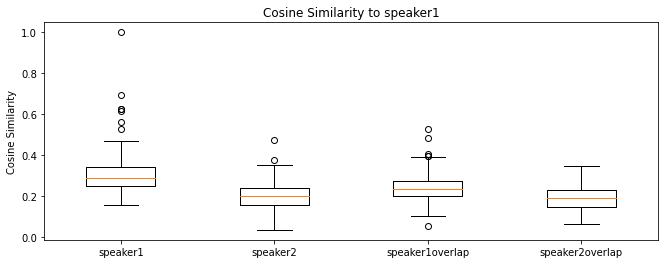

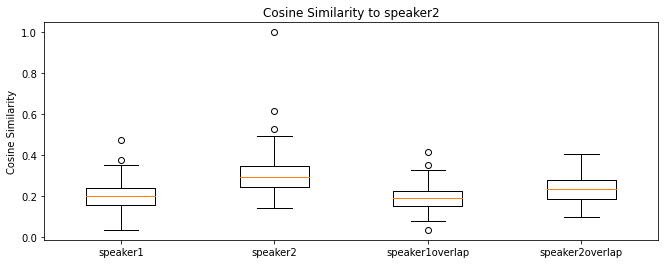

In [7]:
def plot_cosine_similarity_boxplots(scores, speaker):
    labels = list(scores[speaker].keys())
    data = [scores[speaker][label] for label in labels]

    fig, ax = plt.subplots(figsize=(11, 4))
#     ax.yaxis.grid(True, alpha=1, color='black', linestyle='--', linewidth=0.3)
    ax.boxplot(data)
    
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Cosine Similarity to {speaker}')
    
    plt.show()

plot_cosine_similarity_boxplots(scores1, 'speaker1')
plot_cosine_similarity_boxplots(scores1, 'speaker2')

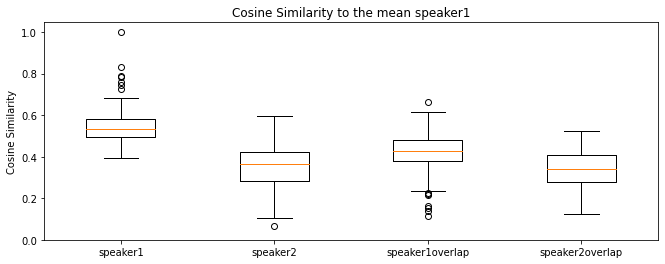

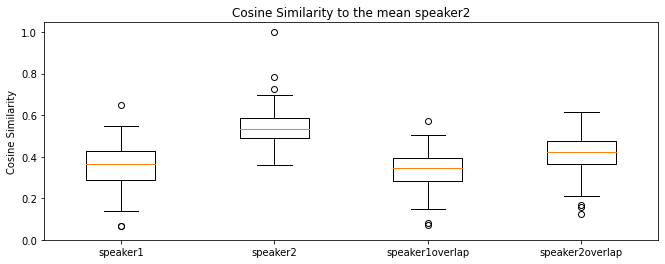

In [8]:
def plot_cosine_similarity_boxplots(scores, speaker):
    labels = list(scores[speaker].keys())
    data = [scores[speaker][label] for label in labels]

    fig, ax = plt.subplots(figsize=(11, 4))
#     ax.yaxis.grid(True, alpha=1, color='black', linestyle='--', linewidth=0.3)
    ax.boxplot(data)
    
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Cosine Similarity to the mean {speaker}')
    
    plt.show()

plot_cosine_similarity_boxplots(scores2, 'speaker1')
plot_cosine_similarity_boxplots(scores2, 'speaker2')

## 3. PCA 3D plot

In [23]:
# set interactive plot
%matplotlib notebook

In [129]:
max_n_files = 200

non_overlap_embeddings = []
overlap_embeddings = []
overlap_percents = []

for i, file in enumerate(dataset):
    if i >= max_n_files:
        break
    
    non_overlap_embeddings.extend([segment['embedding'] for segment in file['speaker1']])
    non_overlap_embeddings.extend([segment['embedding'] for segment in file['speaker2']])
    
    for segment in file['speaker1overlap']:
        overlap_embeddings.append(segment['embedding'])
        overlap_percents.append(segment['overlap%'])
        
    for segment in file['speaker2overlap']:
        overlap_embeddings.append(segment['embedding'])
        overlap_percents.append(segment['overlap%'])

# combine the embeddings into one array for PCA
embeddings = non_overlap_embeddings + overlap_embeddings
labels = ['Non-Overlap'] * len(non_overlap_embeddings) + ['Overlap'] * len(overlap_embeddings)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(embeddings)

In [130]:
alpha_regular=0.4
alpha_overlap=0.7
size=1
color_map = {
    'Non-Overlap': 'blue',
    'Overlap': 'red', # currently overwritten by the colormap gradient but used for the legend
}

limit = (-1000, 1000)

# create masks for each dimension
x_mask = (principal_components[:, 0] > limit[0]) & (principal_components[:, 0] < limit[1])
y_mask = (principal_components[:, 1] > limit[0]) & (principal_components[:, 1] < limit[1])
z_mask = (principal_components[:, 2] > limit[0]) & (principal_components[:, 2] < limit[1])
mask = x_mask & y_mask & z_mask

# mask data
principal_components = principal_components[mask]
labels = np.array(labels)[mask]

overlap_percents_full = np.full(len(embeddings), np.nan)
overlap_percents_full[len(non_overlap_embeddings):] = overlap_percents
overlap_percents = overlap_percents_full[mask]

<IPython.core.display.Javascript object>


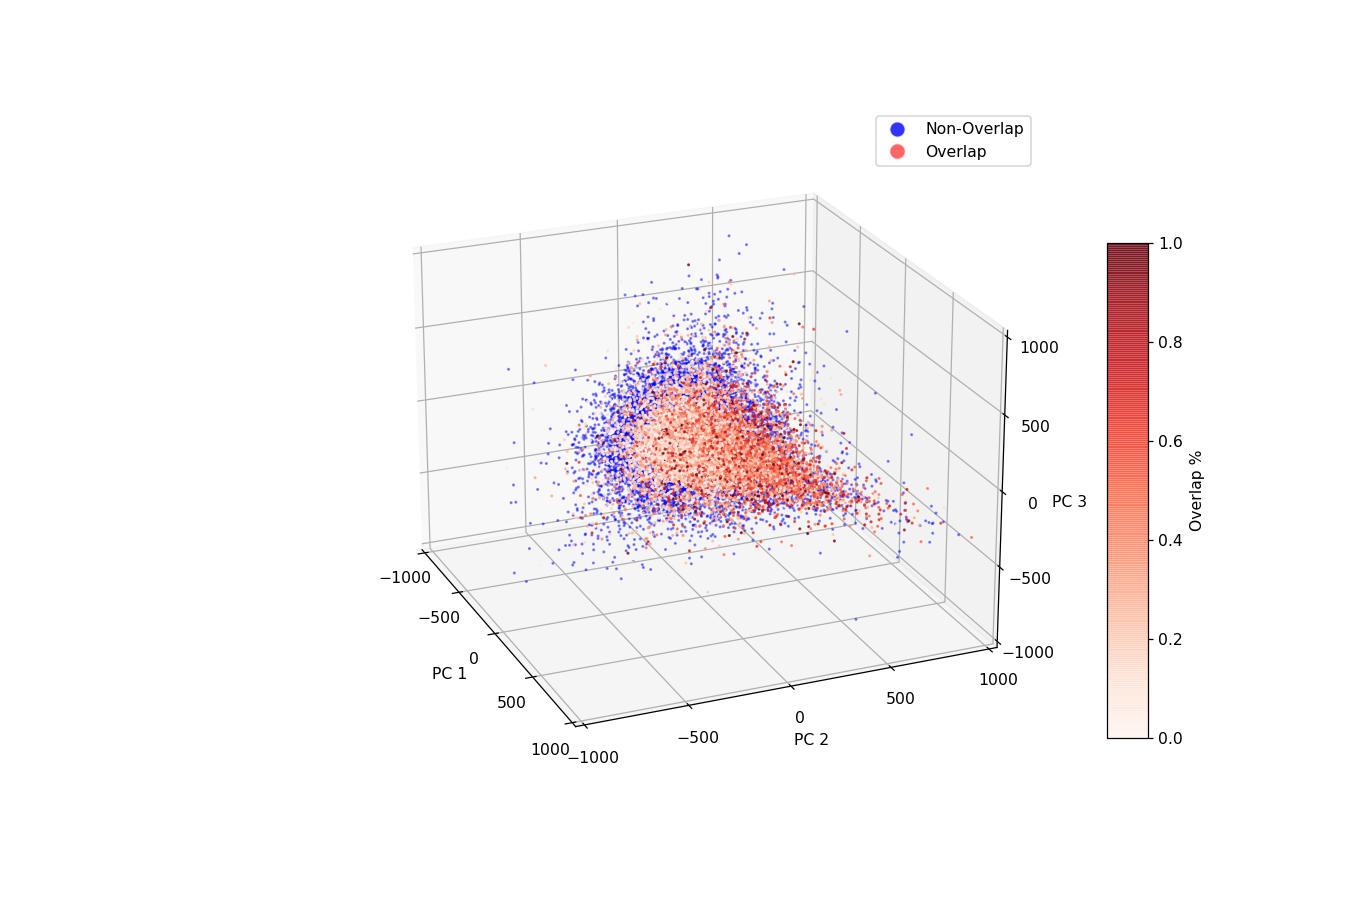

In [145]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# non-overlap
mask = labels == 'Non-Overlap'
ax.scatter(principal_components[mask, 0], principal_components[mask, 1], principal_components[mask, 2], 
           c=color_map['Non-Overlap'], label='Non-Overlap', alpha=alpha_regular, s=size)

# overlap
mask = labels == 'Overlap'
sc = ax.scatter(principal_components[mask, 0], principal_components[mask, 1], principal_components[mask, 2], 
                c=overlap_percents[mask], cmap=plt.cm.Reds, label='Overlap', alpha=alpha_overlap, s=size)


# colorbar for overlap percentages
cbaxes = fig.add_axes([0.82, 0.18, 0.03, 0.55]) 
plt.colorbar(sc, cax=cbaxes, label='Overlap %')

ax.set_xlim(limit)
ax.set_ylim(limit)
ax.set_zlim(limit)

ax.set_xticks(list(range(limit[0], limit[1]+1, 500)))
ax.set_yticks(list(range(limit[0], limit[1]+1, 500)))
ax.set_zticks(list(range(limit[0], limit[1]+1, 500)))

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# dotsize is small so we make custom dots in the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Non-Overlap'], 
                          markersize=10, label='Non-Overlap', alpha=0.8),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Overlap'], 
                          markersize=10, label='Overlap', alpha=0.6)]
ax.legend(handles=legend_elements)

plt.show()